#JRW, HW4 Solution, DATSCI W261, October 2015

##HW 4.0: MRJob short answer responses
####What is mrjob? How is it different from Hadoop MapReduce?
>Mrjob is a Python package for running Hadoop streaming jobs. 
Mrjob is a python-based framework that assists you in submitting your job 
to the Hadoop job tracker and in running each individual step under Hadoop Streaming.
Hadoop is a general software implementation for MapReduce programming 
and the MapReduce execution framework.

####What are the mapper_final(), combiner_final(), reducer_final() methods? When are they called?
>These methods run a user-defined action. They are called 
as part of the life cycle (init, main, and final) of
the mapper, combiner, and reducer methods once 
they have processed all input and have completed execution.

##HW4.1: Serialization short answer responses
####What is serialization in the context of mrjob or Hadoop?
>Serialization is the process of turning structured objects into a byte stream. 
In the context of Hadoop, serialization is leveraged for compression 
to reduce network and disk loads. Contrast this to mrjob, where serialization 
is leveraged to convienentally pass structured objects 
between mapper, reducer, etc. methods.

####When is it used in these frameworks?
>These frameworks accept and use a variety of serializations 
for input, output, and internal transmissions of data.

####What is the default serialization mode for input and output for mrjob?
>For input, the default serialization mode is raw text (RawValueProtocol), 
and for output (and internal), the default mode is JSON format (JSONProtocol).

##HW 4.2: Preprocessing logfiles on a single node

In [26]:
import re
open("anonymous-msweb-preprocessed.data", "w").close
custID = "NA"
with open("anonymous-msweb.data", "r") as IF:
    for line in IF:
        line = line.strip()
        data = re.split(",",line)
        if data[0] == "C":
            custID = data[1]
            custID = re.sub("\"","",custID)
        if data[0] == "V" and not custID == "NA":
            with open("anonymous-msweb-preprocessed.data", "a") as OF:
                OF.writelines(line+","+"C"+","+custID+"\n")

In [27]:
!head -10 anonymous-msweb-preprocessed.data

V,1000,1,C,10001
V,1001,1,C,10001
V,1002,1,C,10001
V,1001,1,C,10002
V,1003,1,C,10002
V,1001,1,C,10003
V,1003,1,C,10003
V,1004,1,C,10003
V,1005,1,C,10004
V,1006,1,C,10005


##HW 4.3: Find the 5 most frequently visited pages using mrjob from the output of 4.2

In [190]:
%%writefile top5pages.py
#!/usr/bin/env python
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawValueProtocol
import re    
 
class top5pages(MRJob):
    
    OUTPUT_PROTOCOL = RawValueProtocol
    
    pages = ["NA","NA","NA","NA","NA"]
    counts = [0,0,0,0,0]

    def steps(self):
        return [MRStep(
                mapper = self.mapper,
                combiner = self.combiner,
                reducer = self.reducer,
                reducer_final = self.reducer_final
                )]
    
    def mapper(self, _, line):
        data = re.split(",",line)
        pageID = data[1]
        yield pageID,1
        
    def combiner(self,pageID,counts):
        count = sum(counts)
        yield pageID,count

    def reducer(self,pageID,counts):
        count = sum(counts)
        ix = -1
        for i in range(5):
            if count > self.counts[i]:
                ix = i
            else:
                break

        if ix >= 0:
            self.counts.insert(ix+1,count)
            self.pages.insert(ix+1,pageID)
            self.counts = self.counts[1:6]
            self.pages = self.pages[1:6]

    def reducer_final(self):
        self.counts.reverse()
        self.pages.reverse()
        print "The top 5 pages are:"
        for i in range(5):
            yield None,self.pages[i] + "," + str(self.counts[i])

if __name__ == '__main__':
    top5pages.run()

Overwriting top5pages.py


In [191]:
!chmod +x top5pages.py

In [192]:
!./top5pages.py anonymous-msweb-preprocessed.data > top5pages.txt 

using configs in /Users/jakerylandwilliams/.mrjob.conf
creating tmp directory /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/top5pages.jakerylandwilliams.20151004.230439.133824
writing to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/top5pages.jakerylandwilliams.20151004.230439.133824/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/top5pages.jakerylandwilliams.20151004.230439.133824/step-0-mapper-sorted
> sort /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/top5pages.jakerylandwilliams.20151004.230439.133824/step-0-mapper_part-00000
writing to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/top5pages.jakerylandwilliams.20151004.230439.133824/step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/top5pages.jakerylandwilliams.20151004.230439.133824/step-0-reducer_part-00000 -> /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/top5pa

In [193]:
!head -6 top5pages.txt

The top 5 pages are:
1008,10836
1034,9383
1004,8463
1018,5330
1017,5108


##HW 4.4: Find the most frequent visitor of each page using mrjob and the output of 4.2. In this output please include the webpage URL, webpage ID and visitor ID.

In [195]:
%%writefile mostFrequentVisitors.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawValueProtocol
import re    
import operator
 
class mostFrequentVisitors(MRJob):
    
    OUTPUT_PROTOCOL = RawValueProtocol
    
    URLs = {}

    def steps(self):
        return [MRStep(
                mapper = self.mapper,
                combiner = self.combiner,
                reducer_init = self.reducer_init,
                reducer = self.reducer
                )]
    
    def mapper(self, _, line):
        data = re.split(",",line)
        pageID = data[1]
        custID = data[4]
        yield pageID,{custID:1}
        
    def combiner(self,pageID,visits):
        allVisits = {}
        for visit in visits:
            for custID in visit.keys():
                allVisits.setdefault(custID,0)
                allVisits[custID] += visit[custID]
        yield pageID,allVisits
        
    def reducer_init(self):
        with open("anonymous-msweb-URLs.data", "r") as IF:
            for line in IF:
                line = line.strip()
                data = re.split(",",line)
                URL = data[4]
                pageID = data[1]
                self.URLs[pageID] = URL

    def reducer(self,pageID,visits):
        allVisits = {}
        for visit in visits:
            for custID in visit.keys():
                allVisits.setdefault(custID,0)
                allVisits[custID] += visit[custID]
        custID = max(allVisits.iteritems(), key=operator.itemgetter(1))[0]
        yield None,self.URLs[pageID]+","+pageID+","+custID+","+str(allVisits[custID])
        
if __name__ == '__main__':
    mostFrequentVisitors.run()

Overwriting mostFrequentVisitors.py


In [196]:
!chmod +x mostFrequentVisitors.py

In [197]:
!./mostFrequentVisitors.py anonymous-msweb-preprocessed.data --file anonymous-msweb-URLs.data > mostFrequentVisitors.txt

using configs in /Users/jakerylandwilliams/.mrjob.conf
creating tmp directory /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/mostFrequentVisitors.jakerylandwilliams.20151004.230615.796755
writing to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/mostFrequentVisitors.jakerylandwilliams.20151004.230615.796755/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/mostFrequentVisitors.jakerylandwilliams.20151004.230615.796755/step-0-mapper-sorted
> sort /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/mostFrequentVisitors.jakerylandwilliams.20151004.230615.796755/step-0-mapper_part-00000
writing to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/mostFrequentVisitors.jakerylandwilliams.20151004.230615.796755/step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/mostFrequentVisitors.jakerylandwilliams.20151004.230615.796755/step-0-reducer_par

####Check on output
Note that in the output below, the number of visits (col. 4)
for each frequent visitor of each web page is 1. 
So, no page had > 1 visits by any individual, 
and technically every visitor was a most frequent visitor.

In [198]:
!head -25 mostFrequentVisitors.txt

"/regwiz",1000,36585,1
"/support",1001,23995,1
"/athome",1002,35235,1
"/kb",1003,22469,1
"/search",1004,35540,1
"/norge",1005,10004,1
"/misc",1006,27495,1
"/ie_intl",1007,19492,1
"/msdownload",1008,35236,1
"/windows",1009,23995,1
"/vbasic",1010,20915,1
"/officedev",1011,40152,1
"/outlookdev",1012,23657,1
"/vbasicsupport",1013,32727,1
"/officefreestuff",1014,20914,1
"/msexcel",1015,16662,1
"/excel",1016,35542,1
"/products",1017,35234,1
"/isapi",1018,35237,1
"/mspowerpoint",1019,16765,1
"/msdn",1020,40159,1
"/visualc",1021,35234,1
"/truetype",1022,15906,1
"/spain",1023,16079,1
"/iis",1024,20447,1


##HW 4.5: K-means clustering of Twitter users with 1,000 words as features

###MRJob class for 1k dimensional k-means clustering used in parts (A-D)

In [207]:
%%writefile kMeans.py
#!/usr/bin/env python
from mrjob.job import MRJob
from mrjob.step import MRStep
import re    
 
class kMeans(MRJob):

    def steps(self):
        return [MRStep(
                mapper_init = self.mapper_init,
                mapper = self.mapper,
                combiner = self.combiner,
                reducer = self.reducer
                )]
    
    ## mapper_init is responsible for reading in the centroids.
    def mapper_init(self):
        self.centroid_points = [map(float,s.split('\n')[0].split(',')) for s in open("centroids.txt").readlines()]
    
    ## mapper is responsible for finding the centroid 
    ## that is closest to the user (line), and then
    ## passing along the closest centroid's idx with the user vector as:
    ## (k,v) = (idx,[users,1,vector])
    ## where 'users' initially is a singleton vector, [ID]
    
    def mapper(self, _, datstr):
        total = 0
        data = re.split(',',datstr)
        ID = data[0]
        code = int(data[1])
        users = [ID]
        codes = [0,0,0,0]
        codes[code] = 1
        coords = [float(data[i+3])/float(data[2]) for i in range(1000)]
        for coord in coords:
            total += coord

        minDist = 0
        IDX = -1
        for idx in range(len(self.centroid_points)):
            centroid = self.centroid_points[idx]
            dist = 0
            for ix in range(len(coords)):
                dist += (centroid[ix]-coords[ix])**2
            dist = dist ** 0.5
            if minDist:
                if dist < minDist:                    
                    minDist = dist
                    IDX = idx
            else:
                minDist = dist
                IDX = idx
        yield (IDX,[users,1,coords,codes])
    
    ## combiner takes the mapper output and aggregates (sum) by idx-key
    def combiner(self,IDX,data):
        N = 0
        sumCoords = [0*num for num in range(1000)]
        sumCodes = [0,0,0,0]
        users = []
        for line in data:
            users.extend(line[0])
            N += line[1]
            coords = line[2]
            codes = line[3]
            sumCoords = [sumCoords[i]+coords[i] for i in range(len(sumCoords))]
            sumCodes = [sumCodes[i]+codes[i] for i in range(len(sumCodes))]
        yield (IDX,[users,N,sumCoords,sumCodes])

    ## reducer finishes aggregating all mapper outputs
    ## and then takes the means by idx-key. 
    def reducer(self,IDX,data):
        N = 0
        sumCoords = [0*num for num in range(1000)]
        sumCodes = [0,0,0,0]        
        users = []
        for line in data:
            users.extend(line[0])
            N += line[1]
            coords = line[2]
            codes = line[3]
            sumCoords = [sumCoords[i]+coords[i] for i in range(len(sumCoords))]
            sumCodes = [sumCodes[i]+codes[i] for i in range(len(sumCodes))]
        centroid = [sumCoords[i]/N for i in range(len(sumCoords))]
        yield (IDX,[users,N,centroid,sumCodes])

if __name__ == '__main__':
    kMeans.run()

Overwriting kMeans.py


In [203]:
%%writefile kMeans_driver.py
#!/usr/bin/env python
from numpy import random
from kMeans import kMeans
import re,sys
mr_job = kMeans(args=["topUsers_Apr-Jul_2014_1000-words.txt","--file","centroids.txt"])

thresh = 0.0001

scriptName,part = sys.argv

## only stop when distance is below thresh for all centroids
def stopSignal(k,thresh,newCentroids,oldCentroids):
    stop = 1
    for i in range(k):
        dist = 0
        for j in range(len(newCentroids[i])): 
            dist += (newCentroids[i][j] - oldCentroids[i][j]) ** 2
        dist = dist ** 0.5
        if (dist > thresh):
            stop  = 0
            break
    return stop

##################################################################################
# Use four centroids from the coding
##################################################################################
def startCentroidsA():
    k = 4
    centroids = []
    for i in range(k):
        rndpoints = random.sample(1000)
        total = sum(rndpoints)
        centroid = [pt/total for pt in rndpoints]
        centroids.append(centroid)
    return centroids
###################################################################################

###################################################################################
## Geneate random initial centroids around the global aggregate
###################################################################################
def startCentroidsBC(k):
    counter = 0
    for line in open("topUsers_Apr-Jul_2014_1000-words_summaries.txt").readlines():
        if counter == 2:        
            data = re.split(",",line)
            globalAggregate = [float(data[i+3])/float(data[2]) for i in range(1000)]
        counter += 1
    ## perturb the global aggregate for the four initializations    
    centroids = []
    for i in range(k):
        rndpoints = random.sample(1000)
        peturpoints = [rndpoints[n]/10+globalAggregate[n] for n in range(1000)]
        centroids.append(peturpoints)
        total = 0
        for j in range(len(centroids[i])):
            total += centroids[i][j]
        for j in range(len(centroids[i])):
            centroids[i][j] = centroids[i][j]/total
    return centroids
###################################################################################

##################################################################################
# Use four centroids from the coding
##################################################################################
def startCentroidsD():
    k = 4
    centroids = []
    counter = 0
    for line in open("topUsers_Apr-Jul_2014_1000-words_summaries.txt").readlines():
        if counter and counter > 1:        
            data = re.split(",",line)
            coords = [float(data[i+3])/float(data[2]) for i in range(1000)]
            centroids.append(coords)
        counter += 1
    return centroids
###################################################################################

if part == "A":
    k = 4
    centroids = startCentroidsA()
if part == "B":
    k = 2
    centroids = startCentroidsBC(k)
if part == "C":
    k = 4
    centroids = startCentroidsBC(k)
if part == "D":
    k = 4
    centroids = startCentroidsD()

## the totals for each user type
numType = [752,91,54,103]
numType = [float(numType[i]) for i in range(4)]

with open("centroids.txt", 'w+') as f:
    for centroid in centroids:
        centroid = [str(coord) for coord in centroid]
        f.writelines(",".join(centroid) + "\n")

iterate = 0
stop = 0

clusters = ["NA" for i in range(k)]
N = ["NA" for i in range(k)]
while(not stop):
    with mr_job.make_runner() as runner:
        runner.run()
        oldCentroids = centroids[:]
        clusterPurities = []
        for line in runner.stream_output():
            key,value =  mr_job.parse_output_line(line)
            clusters[key] = value[0]
            N[key] = value[1]
            centroids[key] = value[2]
            sumCodes = value[3]
            clusterPurities.append(float(max(sumCodes))/float(sum(sumCodes)))
        ## update the centroids
        with open("centroids.txt", 'w+') as f:
            for centroid in centroids:
                centroid = [str(coord) for coord in centroid]
                f.writelines(",".join(centroid) + "\n")
        
        print str(iterate+1)+","+",".join(str(purity) for purity in clusterPurities)
        stop = stopSignal(k,thresh,centroids,oldCentroids)
        if not iterate:
            stop = 0
    iterate += 1

Overwriting kMeans_driver.py


In [204]:
!chmod +x kMeans.py kMeans_driver.py

####Run k-means for parts A-D

In [165]:
!./kMeans_driver.py A > purities-A.txt

In [161]:
!./kMeans_driver.py B > purities-B.txt

In [162]:
!./kMeans_driver.py C > purities-C.txt

In [205]:
!./kMeans_driver.py D > purities-D.txt

####Plot cluster purity output

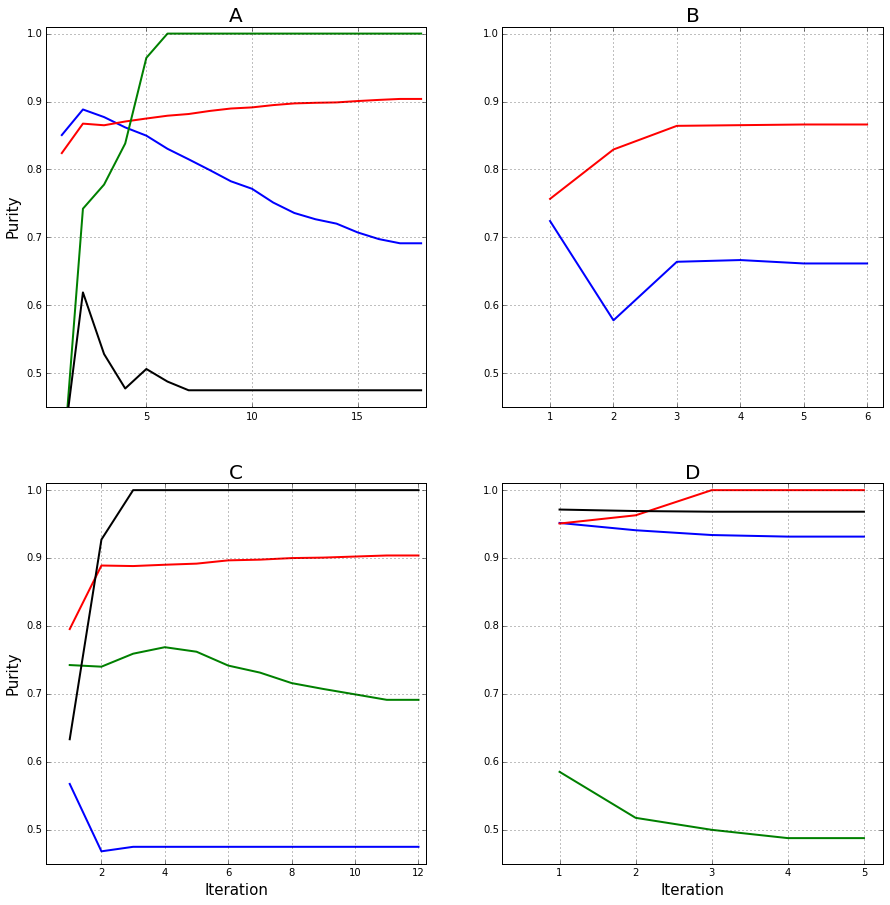

In [209]:
from matplotlib import pyplot as plot
import numpy as np
import re
%matplotlib inline

k = 4
plt.figure(figsize=(15, 15))

## function loads data from any of the 4 initializations
def loadData(filename):
    purities = {}
    f = open(filename, 'r')
    for line in f:
        line  = line.strip()
        data = re.split(",",line)
        iterations.append(int(data[0]))
        i = 0
        for i in range(len(data)):
            if i:
                purities.setdefault(i,[])
                purities[i].append(float(data[i])) 
    return purities

## load purities for initialization A
purities = {}
purities = loadData("purities-A.txt")
iterations = [i+1 for i in range(len(purities[1]))]

## plot purities for initialization A
plot.subplot(2,2,1)
plot.axis([0.25, max(iterations)+0.25,0.45, 1.01])
plot.plot(iterations,purities[1],'b',lw=2)
plot.plot(iterations,purities[2],'r',lw=2)
plot.plot(iterations,purities[3],'g',lw=2)
plot.plot(iterations,purities[4],'black',lw=2)
plot.ylabel('Purity',fontsize=15)
plot.title("A",fontsize=20)
plot.grid(True)

## load purities for initialization A
purities = {}
purities = loadData("purities-B.txt")
iterations = [i+1 for i in range(len(purities[1]))]

## plot purities for initialization B
plot.subplot(2,2,2)
plot.axis([0.25, max(iterations)+0.25,0.45, 1.01])
plot.plot(iterations,purities[1],'b',lw=2)
plot.plot(iterations,purities[2],'r',lw=2)
plot.title("B",fontsize=20)
plot.grid(True)

## load purities for initialization C
purities = {}
purities = loadData("purities-C.txt")
iterations = [i+1 for i in range(len(purities[1]))]

## plot purities for initialization C
plot.subplot(2,2,3)
plot.axis([0.25, max(iterations)+0.25,0.45, 1.01])
plot.plot(iterations,purities[1],'b',lw=2)
plot.plot(iterations,purities[2],'r',lw=2)
plot.plot(iterations,purities[3],'g',lw=2)
plot.plot(iterations,purities[4],'black',lw=2)
plot.xlabel('Iteration',fontsize=15)
plot.ylabel('Purity',fontsize=15)
plot.title("C",fontsize=20)
plot.grid(True)

## load purities for initialization D
purities = {}
purities = loadData("purities-D.txt")
iterations = [i+1 for i in range(len(purities[1]))]

## plot purities for initialization D
plot.subplot(2,2,4)
plot.axis([0.25, max(iterations)+0.25,0.45, 1.01])
plot.plot(iterations,purities[1],'b',lw=2)
plot.plot(iterations,purities[2],'r',lw=2)
plot.plot(iterations,purities[3],'g',lw=2)
plot.plot(iterations,purities[4],'black',lw=2)
plot.xlabel('Iteration',fontsize=15)
plot.title("D",fontsize=20)
plot.grid(True)


###Discussion
As a general note, our comparison of initializations must be 'taken with a grain of salt,' 
as A,B, and C all incorporate some randomization into initialization, 
leading to results that will vary from run to run.
If we wished to compare the randomization initializations with greater confidence,
it would be best to run our experiment a number of times, 
recording purities at convergence, the numbers of iterations before convergence, etc., 
and summarizing these results across runs.

The above being said, in the printout above we can see across those runs with k=4 (A,B, and D), 
that the 'trained' centroid initializations (D) succeeded in converging in the fewest iterations.
In addition, we can see that when D is compared to all other initializations,
the top three (most pure) clusters are generally purer (>90%) after convergence,
indicating that the labeling of users accompanying the data are likely meaningful.
Of all of the initializations, we can see that B performs the worst with regard to 
cluster purity. However, this not exactly a fair comparison, as the purities of 2 clusters
with 4 labels will necessarily be low---it is not possible to isolate all user types!
However, if we wished to see the value of this initialization 
in the context of the dataset, we could take note of whether 
the two most human classes (0 and 3) are clustered together, 
and separate from the two most automated classes (1 and 2),
which is likely the case, but would require keeping track of the
number of each user type present in each cluster (at convergence).

Looking closer at D, we can see that one of the clusters is very non-pure, 
indicating that some users were discordant with respect to their classes, 
forming a mixed cluster in terms of word-frequency.
However, we must be careful not to mislead ourselves while interpreting these results,
as we do not know which user class dominates each cluster. Noting that approximately
75% of all users are labeled as human, it is possible for all clusters to be dominated
by the human class. This however, is not the case, and could be made clear through further analysis,
plotting the numbers of each type present in each cluster at convergence
(which would also inform us of the fact that the least pure cluster is a split of 
robots and cyborgs, who can actually be quite similar!).
